In [1]:
import os
import ast
import spacy
import numpy as np
import pandas as pd
import statistics
from clean_text import *
from stop_words import stopwords
from tqdm import tqdm

tqdm.pandas()
nlp = spacy.load("en_core_web_sm")

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:997)>


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.colors as mcolors

rcParams['figure.dpi'] = 500
rcParams['savefig.dpi'] = 500
rcParams['font.family'] = 'Serif'
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 18
rcParams['figure.titlesize'] = 18

### Mapping POI types

In [ ]:
mapping_df1 = pd.read_csv('google_categories_mapping.csv')
mapping_df2 = pd.read_excel('places_summary_hsh.xlsx')
mapping_df1 = mapping_df1.dropna()
mapping_df2 = mapping_df2.dropna()

google_to_naics3 = dict(zip(mapping_df1['category'], mapping_df1['3-digit NAICS Title']))
naics3_to_naics2 = dict(zip(mapping_df1['3-digit NAICS Title'], mapping_df1['2-digit NAICS Title']))
naics3_to_categories = dict(zip(mapping_df2['3-digit NAICS Title'], mapping_df2['Categories']))

In [ ]:
def replace_naics(lst, dict_map):
    """Return the NAICS code in the list."""
    return [dict_map.get(item, item) for item in lst]

def replace_category(lst, dict_map):
    """Return the category with the most common category in the list."""
    values = list()
    for item in lst:
        if item in dict_map:
            values.append(dict_map[item])
        values = [x for x in values if x is not None]

    values = [x for x in values if x is not None]
    l1 = len(set(values))
    l2 = len(values)
    if l1 == l2 and l1 != 0:
        return values[0]
    elif l1 > 1 and l1 != l2:
        return statistics.mode(values)
    else:
        return None

In [ ]:
read_dir = "parking-places-metrics"
files = [file for file in os.listdir(read_dir) if file.endswith('.csv')]
files = sorted(files)

dfs = list()

for file in files:
    filepath = os.path.join(read_dir, file)
    state_df = pd.read_csv(filepath)
    state_df['3-digit-naics'] = state_df['category'].apply(lambda x: replace_naics(ast.literal_eval(x), google_to_naics3))
    state_df['2-digit-naics'] = state_df['3-digit-naics'].apply(lambda x: replace_naics(x, naics3_to_naics2))
    state_df['2-digit-naics'] = state_df['2-digit-naics'].apply(lambda x: x[0] if len(set(x)) == len(x) else statistics.mode(x))
    state_df['categories'] = state_df['3-digit-naics'].apply(lambda x: replace_category(x, naics3_to_categories))
    filtered_df = state_df[state_df['total_parking_reviews']>=10]
    print(filepath, len(state_df), len(filtered_df))
    filtered_df = filtered_df[filtered_df['categories'].notna()]
    dfs.append(filtered_df)

df = pd.concat(dfs)
df.head(5)

### POI types

In [3]:
pois_df = pd.read_pickle('pois_parking_with_socioinfo.pkl')
rural_df = pois_df[pois_df['Rural_Population_R'] >= 100]
urban_df = pois_df[pois_df['Urbanized_Areas_Population_R'] >= 100]

rural_pois = list(set(rural_df['gmap_id'].tolist()))
urban_pois = list(set(urban_df['gmap_id'].tolist()))

In [ ]:
set(pois_df['Categories'].tolist())

In [4]:
restaurant_df = pois_df[pois_df['Categories'] == 'Restaurant']
retail_df = pois_df[pois_df['Categories'] == 'Retail Trade']
service_df = pois_df[pois_df['Categories'] == 'Personal Service']
recreation_df = pois_df[pois_df['Categories'] == 'Recreation']
apartment_df = pois_df[pois_df['Categories'] == 'Apartment']
hotel_df = pois_df[pois_df['Categories'] == 'Hotel']

restaurant_pois = list(set(restaurant_df['gmap_id'].tolist()))
retail_pois = list(set(retail_df['gmap_id'].tolist()))
service_pois = list(set(service_df['gmap_id'].tolist()))
recreation_pois = list(set(recreation_df['gmap_id'].tolist()))
apartment_pois = list(set(apartment_df['gmap_id'].tolist()))
hotel_pois = list(set(hotel_df['gmap_id'].tolist()))

### Clean reviews

In [ ]:
read_dir = "parking-pos-review-classification"
files = [file for file in os.listdir(read_dir) if file.endswith('.csv')]
files = sorted(files)

review_dfs = list()

for file in files:
    filepath = os.path.join(read_dir, file)
    state_df = pd.read_csv(filepath)
    review_dfs.append(state_df)

review_df = pd.concat(review_dfs)
review_df.head(5)

In [ ]:
review_df['clean_text'] = review_df['parking_text'].progress_apply(lambda x: clean_text(x))
review_df.head(5)

In [ ]:
# review_df.to_pickle('parking-pos-review-classification-cleaned.pkl')

### Generate word frequencies

In [5]:
review_df = pd.read_pickle('parking-pos-review-classification-cleaned.pkl')

In [6]:
urban_reviews = review_df[review_df['gmap_id'].isin(urban_pois)]
rural_reviews = review_df[review_df['gmap_id'].isin(rural_pois)]
restaurant_reviews = review_df[review_df['gmap_id'].isin(restaurant_pois)]
retail_reviews = review_df[review_df['gmap_id'].isin(retail_pois)]
service_reviews = review_df[review_df['gmap_id'].isin(service_pois)]
recreation_reviews = review_df[review_df['gmap_id'].isin(recreation_pois)]
apartment_reviews = review_df[review_df['gmap_id'].isin(apartment_pois)]
hotel_reviews = review_df[review_df['gmap_id'].isin(hotel_pois)]
print('urban reviews', len(urban_reviews))
print('rural reviews', len(rural_reviews))
print('restaurant reviews', len(restaurant_reviews))
print('retail reviews', len(retail_reviews))
print('service reviews', len(service_reviews))
print('recreation reviews', len(recreation_reviews))
print('apartment reviews', len(apartment_reviews))
print('hotel reviews', len(hotel_reviews))

urban reviews 3910511
rural reviews 273762
restaurant reviews 1236516
retail reviews 1314274
service reviews 284063
recreation reviews 843919
apartment reviews 211359
hotel reviews 743429


In [10]:
def generate_topic_words(review_df):
    """Generate words for the review data."""
    # Generate word frequencies for overall and each sentiment category
    def word_frequencies(series):
        word_counts = {}
        for text in series:
            for word in text.split():
                if word in word_counts:
                    word_counts[word] += 1
                else:
                    word_counts[word] = 1
        return word_counts

    # Calculate frequencies
    topic_freq = word_frequencies(review_df['clean_text'])
    pos_freq = word_frequencies(review_df[review_df['predicted_labels'] == 'positive']['clean_text'])
    neg_freq = word_frequencies(review_df[review_df['predicted_labels'] == 'negative']['clean_text'])
    neu_freq = word_frequencies(review_df[review_df['predicted_labels'] == 'neutral']['clean_text'])

    # Convert frequencies to DataFrame
    topic_word = pd.DataFrame(list(topic_freq.items()), columns=['word', 'count'])
    topic_word['pos_count'] = topic_word['word'].map(pos_freq).fillna(0)
    topic_word['neg_count'] = topic_word['word'].map(neg_freq).fillna(0)
    topic_word['neu_count'] = topic_word['word'].map(neu_freq).fillna(0)

    # Calculate saliences and valences of words
    topic_word['salience'] = np.log10(topic_word['count'] + 1)  # Add 1 to avoid log(0)
    sum_count = (topic_word['pos_count'] + topic_word['neg_count'] + topic_word['neu_count'])
    topic_word['valence'] = (topic_word['pos_count'] - topic_word['neg_count']) / sum_count
    topic_word = topic_word.sort_values('salience', ascending=False)
    return topic_word

In [13]:
# Generate topic words for all POIs
all_topic_word = generate_topic_words(review_df)
all_topic_word

# Generate topic words for rural and urban POIs
rural_topic_word = generate_topic_words(rural_reviews)
urban_topic_word = generate_topic_words(urban_reviews)

# Generate topic words for each POI category
hotel_topic_word = generate_topic_words(hotel_reviews)
apartment_topic_word = generate_topic_words(apartment_reviews)
restaurant_topic_word = generate_topic_words(restaurant_reviews)
retail_topic_word = generate_topic_words(retail_reviews)
service_topic_word = generate_topic_words(service_reviews)
recreation_topic_word = generate_topic_words(recreation_reviews)

### Select top words for plotting

In [27]:
def extract_words(text):
    """Extract nouns and adjectives from the text."""
    doc = nlp(text)
    nouns_adjectives = [token.text for token in doc if (token.pos_ == "NOUN" or token.pos_ == "ADJ")]
    return " ".join(nouns_adjectives)

def filter_words(topic_word):
    """Filter words based on several identified conditions."""
    topic_word = topic_word[topic_word['word'].apply(lambda x: len(x) > 2)].reset_index(drop=True)
    topic_word = topic_word[~topic_word['word'].str.contains('|'.join(stopwords))]
    topic_word['is_noun_adj'] = topic_word['word'].apply(lambda x: bool(extract_words(x)))
    topic_word = topic_word[topic_word['is_noun_adj']]
    topic_word = topic_word.drop(columns=['is_noun_adj']).reset_index(drop=True)
    return topic_word

def select_top_words(topic_word, top_n):
    """Select the top words for plotting."""
    top_word = topic_word[:1000]
    top_word = filter_words(top_word)[:top_n]
    return top_word

In [ ]:
all_top_word = select_top_words(all_topic_word, 100)
urban_top_word = select_top_words(urban_topic_word, 50)
rural_top_word = select_top_words(rural_topic_word, 50)
restaurant_top_word = select_top_words(restaurant_topic_word, 50)
retail_top_word = select_top_words(retail_topic_word, 50)
service_top_word = select_top_words(service_topic_word, 50)
recreation_top_word = select_top_words(recreation_topic_word, 50)
hotel_top_word = select_top_words(hotel_topic_word, 50)
apartment_top_word = select_top_words(apartment_topic_word, 50)

### Generate image for LSVA analysis

In [55]:
from adjustText import adjust_text
import matplotlib.pyplot as plt

def plot_scatter(ax, top_word, title):
    """Plot the scatter plot."""
    ax.scatter(top_word['salience'], top_word['valence'],
               s=100,  # marker size
               marker='o',  # marker style
               edgecolors=['red' if valence <= 0 else 'blue' for valence in top_word['valence']],  # marker edge color
               facecolors='none',
               linewidths=2)
    texts = []
    for i, word in enumerate(top_word['word']):
        texts.append(ax.text(top_word['salience'].iloc[i], top_word['valence'].iloc[i], word, fontsize=14))
    
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))
    #ax.set_xlim(3, 6)
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel('Salience')
    ax.set_ylabel('Valence')
    ax.axhline(y=0, color='gray', linestyle='--')
    ax.set_title(title)


def create_figure(top_words_list, titles):
    """Arrange the scatter plots in a figure."""
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 2)
    # First row - all_top_word spanning two columns
    ax0 = fig.add_subplot(gs[0, :])
    plot_scatter(ax0, top_words_list[0], titles[0])
    # Second row
    ax1 = fig.add_subplot(gs[1, 0])
    plot_scatter(ax1, top_words_list[1], titles[1])
    ax2 = fig.add_subplot(gs[1, 1])
    plot_scatter(ax2, top_words_list[2], titles[2])
    
    plt.tight_layout()
    plt.show()

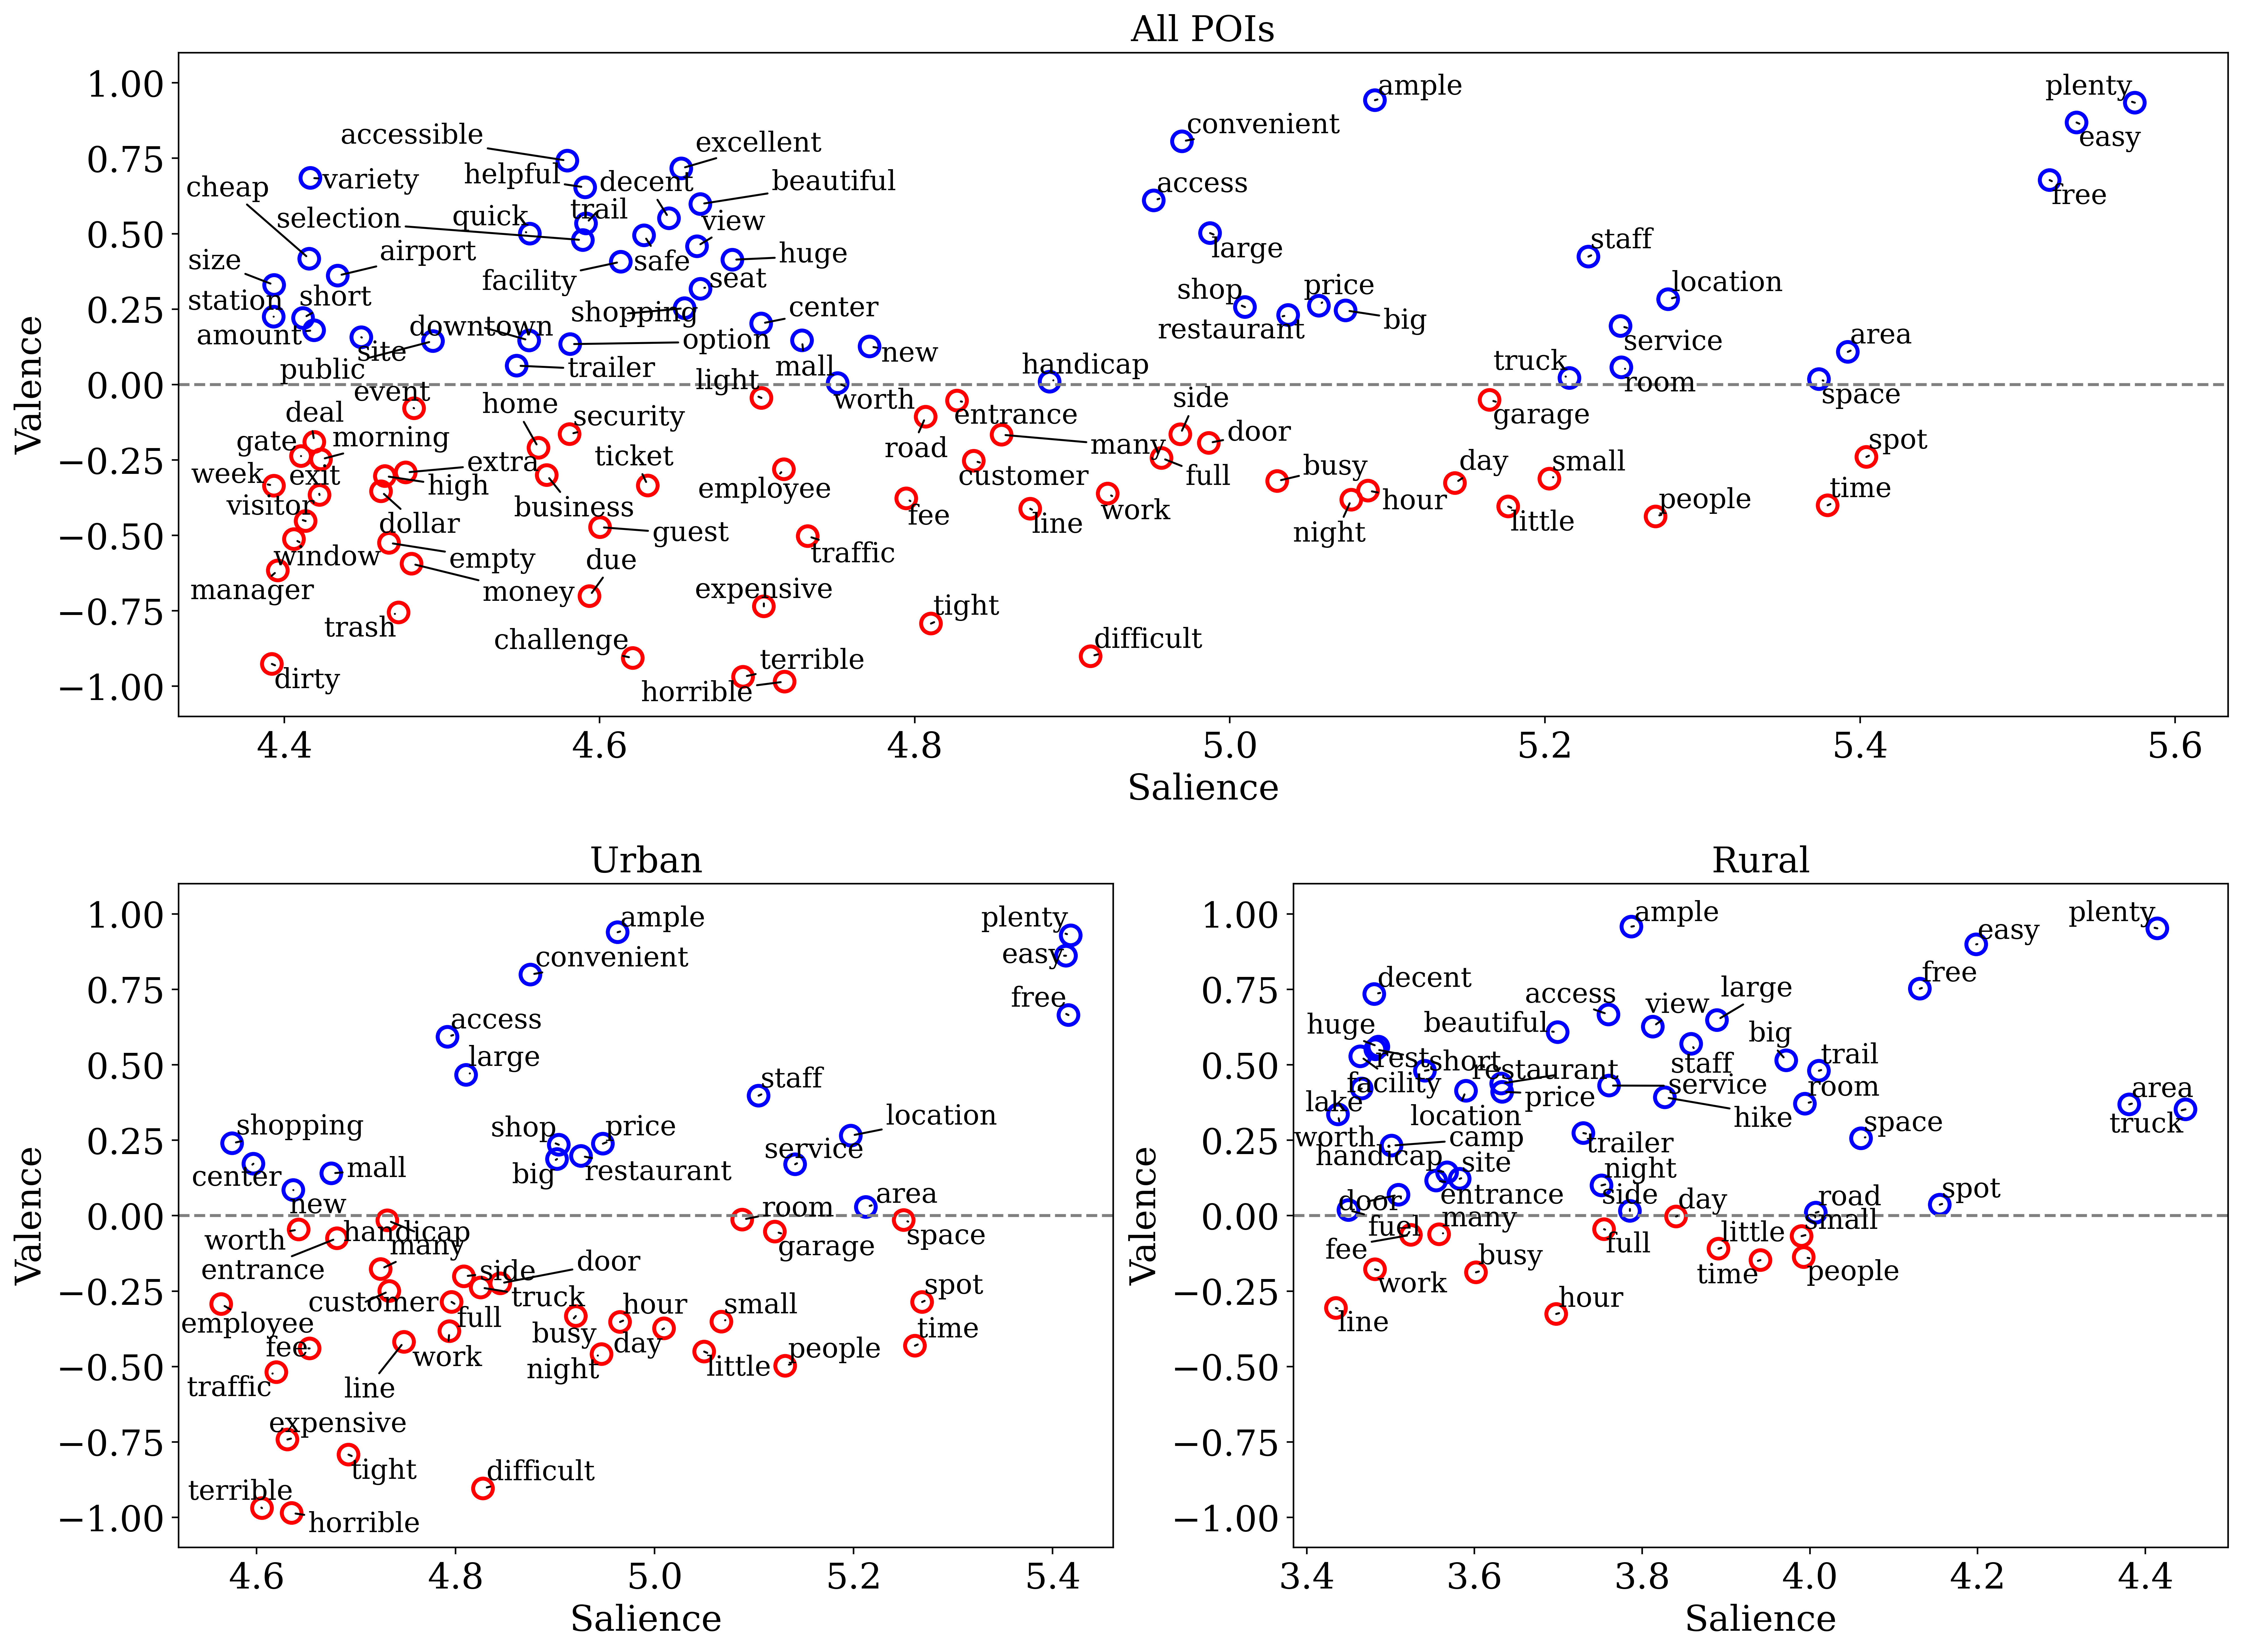

In [56]:
top_words_list = [all_top_word, urban_top_word, rural_top_word]
titles = ['All POIs', 'Urban', 'Rural']
create_figure(top_words_list, titles)

In [60]:
def create_POI_figure(top_words_list, titles):
    """Arrange the scatter plots in a figure."""
    fig = plt.figure(figsize=(18, 18))
    gs = fig.add_gridspec(3, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    plot_scatter(ax1, top_words_list[0], titles[0])
    ax2 = fig.add_subplot(gs[0, 1])
    plot_scatter(ax2, top_words_list[1], titles[1])
    ax3 = fig.add_subplot(gs[1, 0])
    plot_scatter(ax3, top_words_list[2], titles[2])
    ax4 = fig.add_subplot(gs[1, 1])
    plot_scatter(ax4, top_words_list[3], titles[3])
    ax5 = fig.add_subplot(gs[2, 0])
    plot_scatter(ax5, top_words_list[4], titles[4])
    ax6 = fig.add_subplot(gs[2, 1])
    plot_scatter(ax6, top_words_list[5], titles[5])
    
    plt.tight_layout()
    plt.show()

POI_top_words_list = [restaurant_top_word, retail_top_word, service_top_word, recreation_top_word, hotel_top_word, apartment_top_word]
POI_types = ['Restaurant', 'Retail', 'Personal Service', 'Recreation', 'Hotel', 'Apartment']
create_POI_figure(POI_top_words_list, POI_types)